# Examples

This notebooks holds the examples from the paper `Taming the Panda with Python`.

In [1]:
# Panda hostname/IP and Desk login information of your robot
hostname = '192.168.3.100'
username = 'user'
password = 'password'

# panda-py is chatty, activate information log level
import logging
logging.basicConfig(level=logging.INFO)

## Code Block 1

Use the Desk client to connect to the web-application running on the control unit to unlock the brakes and activate the Franka Research Interface (FCI) for robot torque control.

In [2]:
import panda_py

desk = panda_py.Desk(hostname, username, password)
desk.unlock()
desk.activate_fci()

INFO:desk:Login succesful.
INFO:desk:Legacy desk detected.


## Code Block 2

Connect to the robot using the Panda class. The default gripper from Franka Emika does not support real-time control and can be controlled using the libfranka bindings directly.

In [3]:
from panda_py import libfranka

panda = panda_py.Panda(hostname)
gripper = libfranka.Gripper(hostname)

INFO:panda:Connected to robot (172.16.0.2).


## Code Block 3

Simple motion generation in joint space. The call to `get_pose` produces a $4\times 4$ matrix representing the homogeneous transform from robot base to end-effector. The indices $2,3$ refer to third row and fourth column respectively, i.e. the z-coordinate. The position in z is lowered by $0.1\mathrm{m}$ and passed to the inverse kinematics function to produce joint positions. Finally the call to `move_to_joint_position` generates a motion from the current to the desired joint potions.

In [4]:
panda.move_to_start()
pose = panda.get_pose()
pose[2,3] -= .1
q = panda_py.ik(pose)
panda.move_to_joint_position(q)

INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.81 seconds.
INFO:panda:Starting new controller (Trajectory).
INFO:panda:Stopping active controller (Trajectory).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.80 seconds.
INFO:panda:Starting new controller (Trajectory).


True

## Code Block 4

Simple motion generation in Cartesian space. The z-coordinate of the current end-effector pose is lowered by $0.1\mathrm{m}$ as in Code Block 3. However the resulting pose is passed directly to `move_to_pose` to produce a motion in Cartesian space.

In [5]:
panda.move_to_start()
pose = panda.get_pose()
pose[2,3] -= .1
panda.move_to_pose(pose)

INFO:panda:Stopping active controller (Trajectory).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.81 seconds.
INFO:panda:Starting new controller (Trajectory).
INFO:panda:Stopping active controller (Trajectory).
INFO:panda:Initializing motion generation (moveToPose).
INFO:motion:Computed Cartesian trajectory: 1 waypoint, duration 0.42 seconds.
INFO:panda:Starting new controller (Trajectory).


True

## Inline Examples

Various short examples used inline.

In [6]:
print(panda.get_state())
print(panda.get_model())
gripper.grasp(0, 0.2, 10, 0.04, 0.04)
gripper.move(0.08, 0.2)

{"O_T_EE": [0.999874,0.0148893,-0.00325974,0,0.0148838,-0.999878,-0.00171326,0,-0.00328492,0.00166456,-0.999993,0,0.306202,-0.000433196,0.385996,1], "O_T_EE_d": [0.999953,0.00776255,0.00369069,0,0.0077598,-0.99996,0.000758929,0,0.0036965,-0.000730269,-0.999993,0,0.307334,-0.000755249,0.487171,1], "F_T_NE": [0.7071,-0.7071,0,0,0.7071,0.7071,0,0,0,0,1,0,0,0,0.1034,1], "NE_T_EE": [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1], "F_T_EE": [0.7071,-0.7071,0,0,0.7071,0.7071,0,0,0,0,1,0,0,0,0.1034,1], "EE_T_K": [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1], "m_ee": 0.73, "F_x_Cee": [-0.01,0,0.03], "I_ee": [0.001,0,0,0,0.0025,0,0,0,0.0017], "m_load": 0, "F_x_Cload": [0,0,0], "I_load": [0,0,0,0,0,0,0,0,0], "m_total": 0.73, "F_x_Ctotal": [-0.01,0,0.03], "I_total": [0.001,0,0,0,0.0025,0,0,0,0.0017], "elbow": [-0.0126533,-1], "elbow_d": [-0.00180416,-1], "elbow_c": [0,0], "delbow_c": [0,0], "ddelbow_c": [0,0], "tau_J": [0.231179,-4.22711,-0.166156,23.1744,0.565856,2.51057,0.225773], "tau_J_d": [0.264577,-0.753997,0.0864655

True

## Code Block 5

Using the integrated logging mechanism, the libfranka `RobotState` can be logged at a frequency of $1\mathrm{kHz}$. This example creates two end-effector poses `T_0` and `T_1` based on the starting pose, displaced $0.25\mathrm{m}$ to the left and right respectively. Before a motion is generated between these poses, logging is enabled for this Panda instance (line 9). The enable logging function takes the buffer size in number of steps as argument. As such, $2e3$ steps at $1\mathrm{kHz}$ correspond to a buffer holding the state of the past 2 seconds. After the motion is finished, logging is disabled and the buffer retrieved (line 14).

In [7]:
from panda_py import constants
import numpy as np

T_0 = panda_py.fk(constants.JOINT_POSITION_START)
T_0[1, 3] = 0.25
T_1 = T_0.copy()
T_1[1, 3] = -0.25

panda.move_to_pose(T_0)
panda.enable_logging(40000)
panda.move_to_pose(T_1,
                   speed_factor=0.01,
                   stiffness=2 * np.array([600, 600, 600, 600, 250, 150, 50]))
panda.disable_logging()
log = panda.get_log()

panda.move_to_pose(T_0)
panda.enable_logging(10000)
panda.move_to_joint_position(panda_py.ik(T_1))
panda.disable_logging()
joint_log = panda.get_log()

INFO:panda:Stopping active controller (Trajectory).
INFO:panda:Initializing motion generation (moveToPose).
INFO:motion:Computed Cartesian trajectory: 1 waypoint, duration 0.87 seconds.
INFO:panda:Starting new controller (Trajectory).
INFO:panda:Stopping active controller (Trajectory).
INFO:panda:Initializing motion generation (moveToPose).
INFO:motion:Computed Cartesian trajectory: 1 waypoint, duration 29.46 seconds.
INFO:panda:Starting new controller (Trajectory).
INFO:panda:Stopping active controller (Trajectory).
INFO:panda:Initializing motion generation (moveToPose).
INFO:motion:Computed Cartesian trajectory: 1 waypoint, duration 1.60 seconds.
INFO:panda:Starting new controller (Trajectory).
INFO:panda:Stopping active controller (Trajectory).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 3.98 seconds.
INFO:panda:Starting new controller (Trajectory).


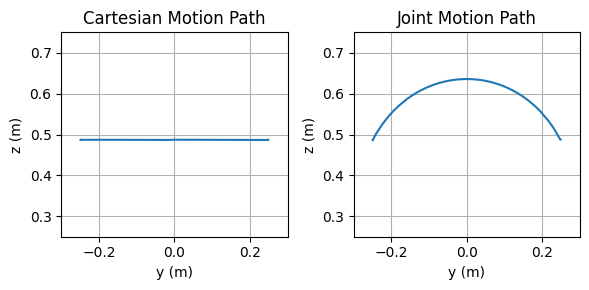

In [8]:
from matplotlib import pyplot as plt

def plot(O_T_EE, ax, title: str):
  ax.plot(O_T_EE[:,13], O_T_EE[:,14])
  ax.set_xlim(-0.3,0.3)
  ax.set_ylim(0.25,0.75)
  ax.set_xlabel('y (m)')
  ax.set_ylabel('z (m)')
  ax.grid(True)
  ax.set_title(title)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3))
plot(np.array(log['O_T_EE']), ax0, 'Cartesian Motion Path')
plot(np.array(joint_log['O_T_EE']), ax1, 'Joint Motion Path')
fig.tight_layout()

## Code Block 6

Running a panda-py controller. After initializing the controller, the current position and orientation are stored in `x0` and `q0` respectively, where `q0` is a quaternion representation of the end-effector orientation. After starting the controller, a `PandaContext` is created from the Panda object (line 10). `PandaContext` is a convenient context manager that executes a loop at a fixed frequency for an optional amount of time. The call to `PandaContext.ok` throttles the loop and also raises any control exceptions that may have been raised by libfranka. Use of `PandaContext` is optional and users are free to manage the control flow how they wish. In this example a periodic linear displacement along the y-axis is added to the initial pose (line 13). This results in the end-effector moving periodically from left to right in straight lines.

> **Info**
>
> This Code Block doesn't run well inside IPython notebooks and may not finish successfully. Please run the example located at `examples/cartesian_impedance.py` instead.


## Code Block 7

Code Block 7: Resolved rate controller with reactive manipulability maximization. This example is from the Robotics Toolbox for Python. To run it on the real hardware with panda-py requires only connecting the inputs and outputs of the control loop to panda-py, i.e., using the joint positions `Panda.q` and providing the control signal to `IntegrateVelocity.set control`. Additionally, the inequality constraints to avoid the joint limits were removed, as panda-py controllers already have integrated joint limit avoidance using impedance control.

> **Info**
>
> This Code Block doesn't run well inside IPython notebooks and may not finish successfully. Please run the example located at `examples/mmc.py` instead.